In [1]:
import wandb

api = wandb.Api()
entity, project = "sayakpaul", "keras-xla-benchmarks"  
runs = api.runs(entity + "/" + project) 
print(f"Total runs: {len(runs)}")

Total runs: 546


In [2]:
from model_mapping import MODEL_NAME_MAPPING

all_variants = [
    variant for k in MODEL_NAME_MAPPING for variant in MODEL_NAME_MAPPING[k]
]
all_variants

['vit_s16',
 'vit_b8',
 'vit_b16',
 'vit_b32',
 'vit_l16',
 'vit_r26_s32',
 'vit_r50_l32',
 'deit_tiny_patch16_224',
 'deit_tiny_distilled_patch16_224',
 'deit_small_patch16_224',
 'deit_small_distilled_patch16_224',
 'deit_base_patch16_224',
 'deit_base_distilled_patch16_224',
 'deit_base_patch16_384',
 'deit_base_distilled_patch16_384',
 'swin_tiny_patch4_window7_224',
 'swin_small_patch4_window7_224',
 'swin_base_patch4_window7_224',
 'swin_base_patch4_window12_384',
 'swin_large_patch4_window7_224',
 'swin_large_patch4_window7_384',
 'swin_s3_tiny_224',
 'swin_s3_small_224',
 'swin_s3_base_224',
 'mixer_b16',
 'mixer_b32',
 'mixer_l16']

In [3]:
import pandas as pd

resolutions = []
accelerators = []

model_families = []
model_variants = []
xla_status = []

flops = []
params = []
throughputs = []

for run in runs:
    run_config = run.config
    run_summary = run.summary._json_dict

    if run_config["variant"] in all_variants:
        model_families.append(run_config["family"])
        model_variants.append(run_config["variant"])
        resolutions.append(run_config["resolution"])
        xla_status.append(run_config["xla"])

        accelerator_name = run.name.split("@")[-1].split("-")[1]
        accelerators.append(accelerator_name)

        flops.append(run_summary["FLOPs (giga)"])
        params.append(run_summary["Num parameters (million)"])
        throughputs.append(run_summary["Throughput (samples/sec)"])

viz_df = pd.DataFrame(
    {
        "model_family": model_families,
        "model_variant": model_variants,
        "resolution": resolutions,
        "xla": xla_status,
        "accelerator": accelerators,
        "flop (giga)": flops,
        "params (million)": params,
        "throughput (samples/sec)": throughputs,
    }
)
viz_df.head()

,model_family,model_variant,resolution,xla,accelerator,flop (giga),params (million),throughput (samples/sec)
0,MLP-Mixer,mixer_l16,224,True,a100,44.60,208.20,524.90
1,MLP-Mixer,mixer_l16,224,False,a100,44.60,208.20,534.34
2,MLP-Mixer,mixer_b32,224,True,a100,3.24,60.29,1486.84
3,MLP-Mixer,mixer_b32,224,False,a100,3.24,60.29,1431.40
4,MLP-Mixer,mixer_b16,224,True,a100,12.62,59.88,1017.92


In [4]:
def plot_topk_per_accelerator(
    accelerator="a100", topk=10, resolution=224, xla_status=True
):
    filtered_df = viz_df[viz_df["accelerator"] == accelerator]
    subset_df = filtered_df.query(f"resolution == {resolution} and xla == {xla_status}")
    topk_df = subset_df.nlargest(topk, ["throughput (samples/sec)"])
    return topk_df

In [5]:
# Adapted from
# https://github.com/nlp-with-transformers/notebooks/blob/main/08_model-compression.ipynb

import matplotlib.pyplot as plt


def plot_metrics(df, savefig=False):
    for model_variant in df["model_variant"]:
        filtered = df.query(f"model_variant == '{model_variant}'")
        plt.scatter(
            filtered["flop (giga)"],
            filtered["throughput (samples/sec)"],
            alpha=0.5,
            s=filtered["params (million)"] * 5,
            label=model_variant,
            marker="o",
        )

    legend = plt.legend(bbox_to_anchor=(1, 1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylabel("Throughput (samples/sec)", fontsize=14)
    plt.xlabel("FLOPS (giga)", fontsize=14)

    accelerator_name = df["accelerator"].unique()[0]
    resolution = df["resolution"].unique()[0]
    xla_status = df["xla"].unique()[0]
    plt.title(
        f"Accelerator: {accelerator_name}, Resolution: {resolution}, XLA: {xla_status}",
        fontsize=14,
    )
    if not savefig:
        plt.show()
    else:
        plot_name = f"{accelerator_name}_{resolution}_{xla_status}.png"
        plt.savefig(plot_name, dpi=300, bbox_inches="tight")

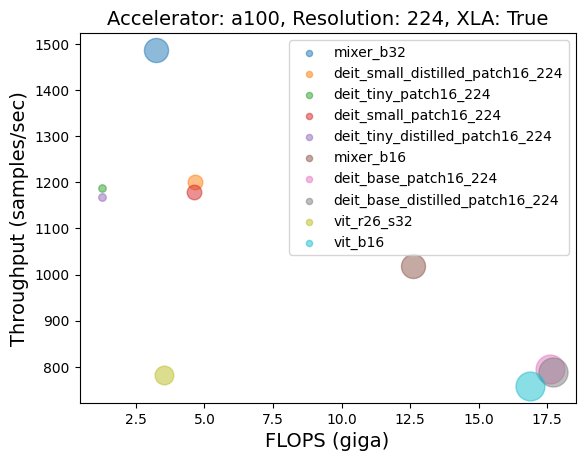

In [6]:
a100_df = plot_topk_per_accelerator("a100")
plot_metrics(a100_df)

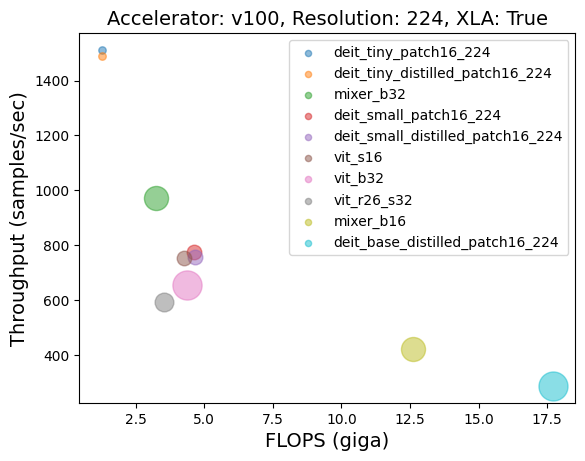

In [7]:
v100_df = plot_topk_per_accelerator("v100")
plot_metrics(v100_df)

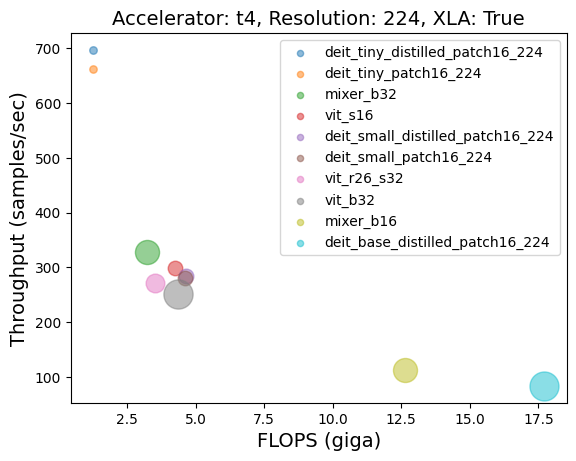

In [8]:
t4_df = plot_topk_per_accelerator("t4")
plot_metrics(t4_df)

In [9]:
viz_df.resolution.unique()

array([224, 384])

In [10]:
# Grouping the dataframe by unique resolutions and finding the 
# model variant with highest throughput per group.
grouped = viz_df.groupby("resolution")["throughput (samples/sec)"].idxmax()

# Selecting the rows with the highest throughput per group.
result = viz_df.loc[grouped, viz_df.columns]
result

,model_family,model_variant,resolution,xla,accelerator,flop (giga),params (million),throughput (samples/sec)
64,DeiT,deit_tiny_patch16_224,224,True,v100,1.27,5.72,1511.59
20,DeiT,deit_base_patch16_384,384,True,a100,55.73,86.86,297.44


In [11]:
grouped = viz_df.groupby(["resolution", "accelerator"])[
    "throughput (samples/sec)"
].idxmax()
result = viz_df.loc[grouped, viz_df.columns]
result

,model_family,model_variant,resolution,xla,accelerator,flop (giga),params (million),throughput (samples/sec)
2,MLP-Mixer,mixer_b32,224,True,a100,3.24,60.29,1486.84
69,DeiT,deit_tiny_distilled_patch16_224,224,True,t4,1.27,5.91,696.79
64,DeiT,deit_tiny_patch16_224,224,True,v100,1.27,5.72,1511.59
20,DeiT,deit_base_patch16_384,384,True,a100,55.73,86.86,297.44
37,DeiT,deit_base_patch16_384,384,True,t4,55.73,86.86,25.20
26,DeiT,deit_base_distilled_patch16_384,384,True,v100,55.84,87.63,92.45
